#### *Analyze a family of RNNs all trained on the same data but with different hyperparameters.*

Essentially, most RNNs fit the muscle activity data (EMG) with almost the same loss.

(This is a very easy task from an ML standpoint.)

But not all such RNNs are equivalent as RNNs are overparametrized, and their internal behavior depends on hyperparameters. Here we investigate this dependence.

The cost function for the RNN
$$ \sum_{t,c}\|\hat{y}(t,c) - y(t,c)\|_2^2 + \lambda_1\|A\|_F^2 + \lambda_2\|C\|_F^2,$$
where $A$ and $C$ are the state-to-state and state-to-output matrices, respectively.

The RNN hyperparameters,
- $\lambda_1$
- $\lambda_2$
- $\sigma_w$ (std dev of noise injected into neurons during training

are compared against various measures of RNN activation trajectories
- mean curvature
- mean curvature (path length normalized)
- mean torsion (generalized curvature)
- trajectory "tangling" (a "global measure of curvature")
- path length
- dimensionality (participation ratio)
- average of the norms of the Jacobian evaluated at all path points
- "noise robustness"
- "structural robustness"

The latter two measures are obtained by resimulating the RNN and injecting noise to the state variables (noise robustness) or by adding a random perturbation to $A$ (structural robustness) and then finding the strength of noise required to drop the EMG fit to $R^2< 0.5$. This is tricky because a small perturbation in $A$ can result in EMG fits that are *qualitiatively* good but *quantitatively* bad (e.g. small frequency changes might result in a huge drop in $R^2$). Thus we use dynamic time warping (DTW) as a measure of loss instead of $MSE$ or $R^2$---first apply DTW then take $R^2$. This minor details turns out to actually make a difference.

----------

### TODO
Do:
- [DONE] Test for 1 condition only
- Lie stuff -- lie bracket, lie derivatives, etc
- regularize the RNN activations maybe
- [DONE] normalize by path length for curvature calculations
- [DONE] check to make sure dtw is working correctly
- plot ref lines for M1 data


# 0. Initial stuff

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [122]:
import numpy as np
import scipy.io as sio
import sklearn as sk

from sklearn import decomposition
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

# For jupyter tensorboarding
from io import BytesIO
from functools import partial
import PIL.Image
from ipywidgets import FloatProgress

from IPython.display import clear_output, Image, display, HTML

import pickle
import os
import pprint as pp

from dtw import dtw
from cdtw import pydtw

from tqdm import tqdm # progress bar

In [123]:
import cyclingrnn.geometric as geo
from cyclingrnn import sigerr
from cyclingrnn.train import *

In [6]:
# sns colormaps
#cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
#sns.set_palette(cmap)
sns.set_context('notebook', font_scale=1.0)

In [40]:
def giant_regplot(df, cols=None, rows=None, logs=[]):

  if not cols:
    cols = df.columns
  for col in cols:
    if len(df[col].unique())==1:
      df.drop(col, axis=1, inplace=True)
  if not cols:
    cols = df.columns
  if not rows:
    rows = df.columns
  
  isnumeric_col = [np.any([isinstance(i, (int, long, float, complex)) for i in df[c]]) for c in cols]  
  isnumeric_row = [np.any([isinstance(i, (int, long, float, complex)) for i in df[r]]) for r in rows]  
  
  fact = 3
  num_cols, num_rows = len(cols), len(rows)
  f, ax = plt.subplots(num_rows, num_cols, figsize=(fact*num_cols, fact*num_rows), sharey=False, sharex=False)
  for ir, row in enumerate(rows):
    for ic, col,  in enumerate(cols):
      logx_bool = col in logs
      if logx_bool:
        ax[ir, ic].set_xscale('log', basex=10)
      logy_bool = row in logs
      if logy_bool:
        ax[ir, ic].set_yscale('log', basex=10)

      if np.logical_xor(isnumeric_row[ir], isnumeric_col[ic]):
        sns.violinplot(x=col, y=row, data=df, ax=ax[ir, ic])
      elif (isnumeric_row[ir] and isnumeric_col[ic]):
        sns.regplot(col, row, df, logx=logx_bool, ax=ax[ir, ic], truncate=False)
        d_range = df[row].max() - df[row].min()
        ax[ir, ic].set_ylim([df[row].min()-0.1*d_range, df[row].max()+0.1*d_range])
        ax[ir, ic].set_xlim([df[col].min(), df[col].max()])

      if ir < num_rows-1:
        ax[ir, ic].xaxis.label.set_visible(False)
      if ic > 0:
        ax[ir, ic].yaxis.label.set_visible(False)



# Visualize results

In [75]:
df_path = '../saves/170216D/df0123.pickle'
df = pickle.load(open(df_path))

In [76]:
df = df[df['R2'] > 0.5]

-------------

In [77]:
df.columns

Index([u'activation', u'beta1', u'beta2', u'learning_rate', u'monkey',
       u'num_neurons', u'rnn_init', u'stddev_out', u'stddev_state', u'MSE',
       u'R2', u'noise_robustness', u'path_length', u'percent_tangling1',
       u'percent_tangling2', u'percent_tangling3', u'sim_num',
       u'struct_robustness', u'mean_curvature', u'mean_torsion'],
      dtype='object')

In [71]:
cols = ['beta1', 'beta2', 'stddev_state', 'learning_rate', 'num_neurons', 'rnn_init', 'activation']
rows = ['R2','MSE','percent_tangling1','percent_tangling2','percent_tangling3','struct_robustness','noise_robustness', 'mean_curvature']
logs = ['beta1', 'beta2', 'stddev_state', 'learning_rate']

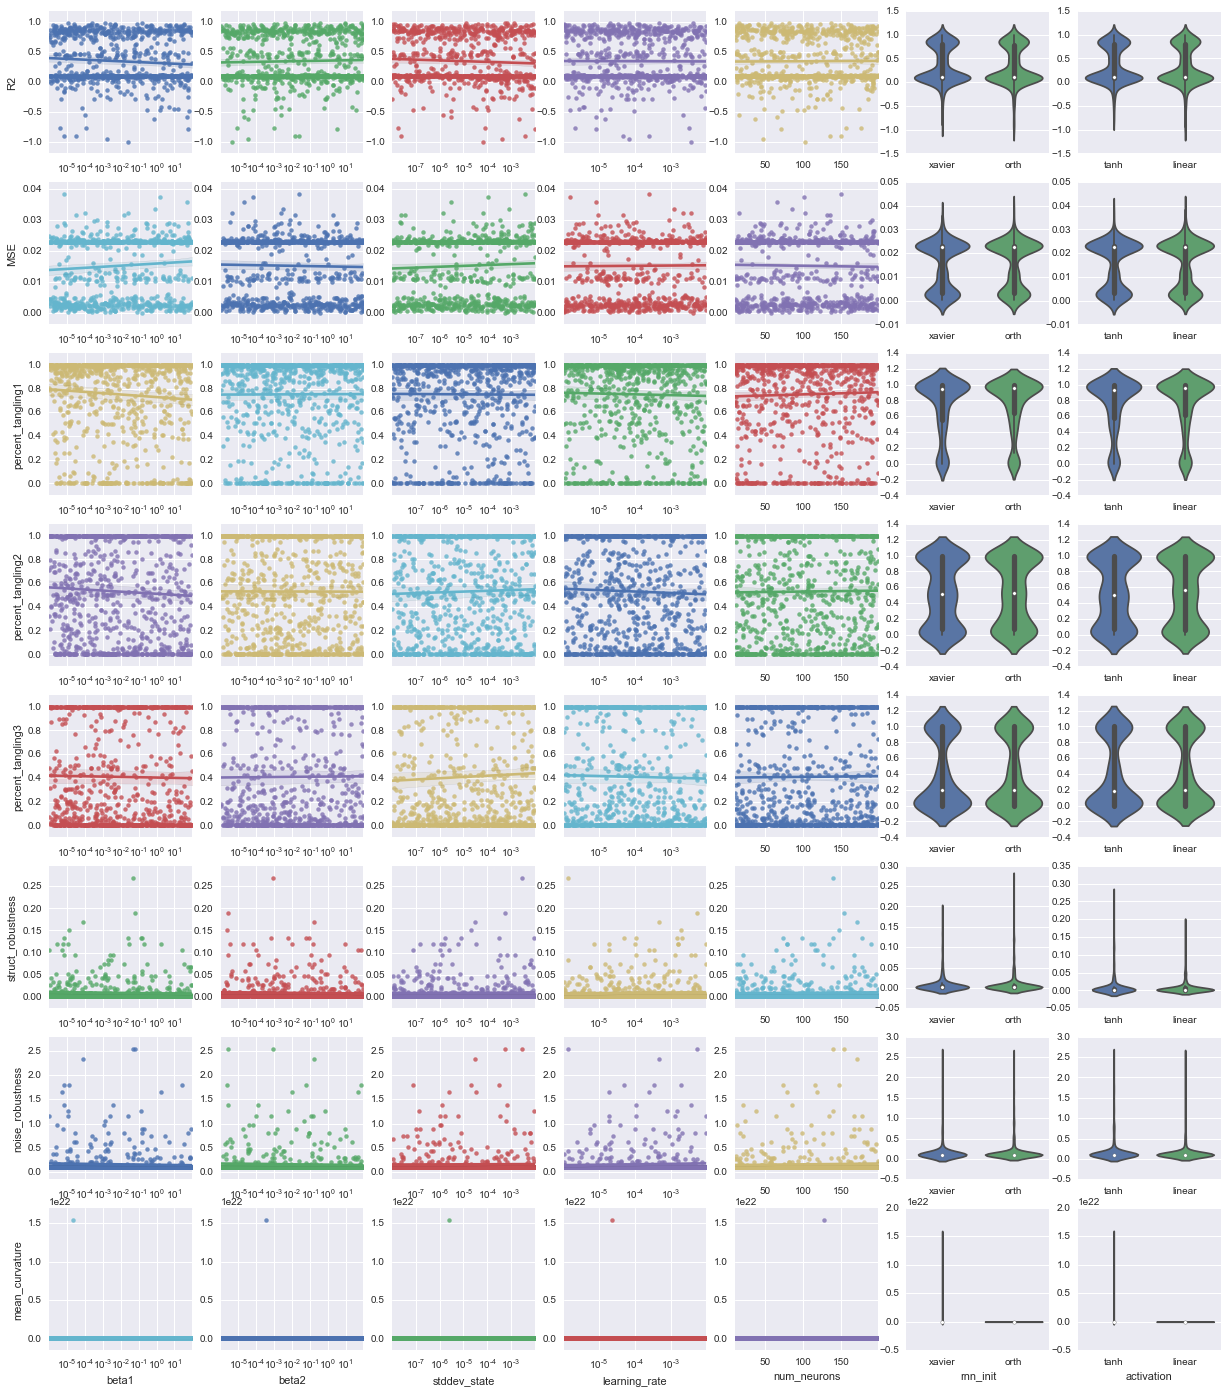

In [72]:
giant_regplot(df, cols, rows, logs)

------------

In [78]:
df.columns

Index([u'activation', u'beta1', u'beta2', u'learning_rate', u'monkey',
       u'num_neurons', u'rnn_init', u'stddev_out', u'stddev_state', u'MSE',
       u'R2', u'noise_robustness', u'path_length', u'percent_tangling1',
       u'percent_tangling2', u'percent_tangling3', u'sim_num',
       u'struct_robustness', u'mean_curvature', u'mean_torsion'],
      dtype='object')

In [79]:
cols = ['struct_robustness','noise_robustness']
rows = ['percent_tangling1','percent_tangling2','percent_tangling3']

logs = ['struct_robustness','noise_robustness']

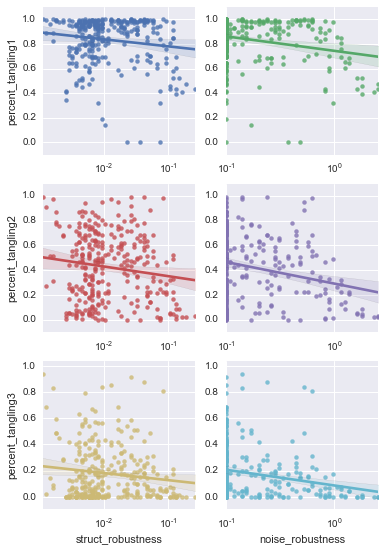

In [81]:
giant_regplot(df, cols, rows, logs)